<h1><center>Air Quality and 311 Requests 2021 - Finding Corelation</center></h1>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

<h2>Reading and Displaying the Data</h2>

In [2]:
# Reading the requests around sensors data
req_around_sensors_df = pd.read_csv("req_around_sensors.csv")
req_around_sensors_df.head() 

,CreatedDate,RequestType,ServiceDate,Latitude,Longitude,DistToSensor,SensorName,SensorIndex,Sensor#
0,2021-01-01 10:55:25,Bulky Items,2021-01-04 00:00:00,34.264866,-118.320353,0.852138,AEnv,85645,0
1,2021-01-01 10:57:45,Bulky Items,2021-01-04 00:00:00,34.266566,-118.310450,1.000676,AEnv,85645,0
2,2021-01-01 12:00:39,Bulky Items,2021-01-04 00:00:00,34.269679,-118.313909,1.988898,AEnv,85645,0
3,2021-01-01 13:45:49,Bulky Items,2021-01-04 00:00:00,34.266567,-118.315061,0.877555,AEnv,85645,0
4,2021-01-01 13:46:40,Bulky Items,2021-01-04 00:00:00,34.266567,-118.315061,1.324943,AEnv,85645,0


In [3]:
# List the Request Type so see if there is any request type that possibly can have an extra 
# impact on air quality
req_around_sensors_df["RequestType"].unique()

array(['Bulky Items', 'Metal/Household Appliances', 'Graffiti Removal',
       'Homeless Encampment', 'Electronic Waste',
       'Illegal Dumping Pickup', 'Multiple Streetlight Issue',
       'Single Streetlight Issue', 'Dead Animal Removal'], dtype=object)

In [4]:
len(req_around_sensors_df)

255116

In [5]:
# reading the aqi for each sensor data

sensors_aqi_df = pd.read_csv('sensors_aqi.csv')
sensors_aqi_df.head()

,date_local,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,sensor_index,sensor_name
0,2021-01-01 16:00:00,3.9435,6.0165,6.8290,25,6,25,27109,AQMD_NASA_248
1,2021-01-02 16:00:00,14.0400,21.6700,24.5025,71,23,71,27109,AQMD_NASA_248
2,2021-01-03 16:00:00,15.7435,27.3480,31.3010,83,29,83,27109,AQMD_NASA_248
3,2021-01-04 16:00:00,6.6400,10.6345,12.0850,44,11,44,27109,AQMD_NASA_248
4,2021-01-05 16:00:00,4.1150,6.8820,7.9315,29,7,29,27109,AQMD_NASA_248


In [6]:
# to_datetime() method converts string format to a DateTime object
sensors_aqi_df['date_local'] = pd.to_datetime(sensors_aqi_df['date_local'])

In [7]:
# Rename the columns
sensors_aqi_df.rename({'date_local': 'Date', 'sensor_name': 'SensorName'}, axis=1, inplace=True)

# Change the form of 'date_local' into "year-month-day" (without hour, minute, and second)
sensors_aqi_df['Date'] = sensors_aqi_df['Date'].dt.date

sensors_aqi_df.head()

,Date,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,sensor_index,SensorName
0,2021-01-01,3.9435,6.0165,6.8290,25,6,25,27109,AQMD_NASA_248
1,2021-01-02,14.0400,21.6700,24.5025,71,23,71,27109,AQMD_NASA_248
2,2021-01-03,15.7435,27.3480,31.3010,83,29,83,27109,AQMD_NASA_248
3,2021-01-04,6.6400,10.6345,12.0850,44,11,44,27109,AQMD_NASA_248
4,2021-01-05,4.1150,6.8820,7.9315,29,7,29,27109,AQMD_NASA_248


In [8]:
# to_datetime() method converts string format to a DateTime object
sensors_aqi_df['Date'] = pd.to_datetime(sensors_aqi_df['Date'])

In [9]:
# Check the type of each columns
sensors_aqi_df.dtypes

Date            datetime64[ns]
pm1.0_cf_1             float64
pm2.5_cf_1             float64
pm10.0_cf_1            float64
pm2.5_aqi                int64
pm10.0_aqi               int64
aqi                      int64
sensor_index             int64
SensorName              object
dtype: object

In [10]:
len(sensors_aqi_df)

3648

<h3>Merging Two DataFrames</h3>

We will merge `req_around_sensors_df` with `sensors_aqi_df`. Since `req_around_sensors_df - Created Date` is not in a daily form, we will use grouping method to turn the dataframe's date into daily time stamp. These are the steps taken when combining the above dataframes: 

1. Because the removal of _Bulky Items, Metal/Household Appliances, Graffiti, Homeless Encampment, Electronic Waste, Illegal Dumping, Dead Animal,_ and addressing _Multiple Streetlight Issue_ and _Single Streetlight Issue_ seems to have an equal likelihood to increase the __AQI__ (they have an equal weight), we will combine them by counting the number of daily request instead. We will insert the count of the daily request in a new column `RequestCount`. 
2. The `DistToSensor` from `req_around_sensors_df` will be averaged daily.

In [11]:
# Make a copy of req_around_sensors_df
req_around_sensors_df1 = req_around_sensors_df.copy()

# to_datetime() method converts string format to a DateTime object
req_around_sensors_df1['CreatedDate'] = pd.to_datetime(req_around_sensors_df1['CreatedDate'])

In [12]:
# Select several columns and assign it to the variable "group1"
group1 = req_around_sensors_df1[['CreatedDate', 'SensorName', 'Sensor#', 'DistToSensor']]

# Set the index of group1
group1.index = group1['CreatedDate']

# Group the SensorName by day and calculate the mean of the DistToSensor
group1 = group1.groupby('SensorName').resample("D").mean()

# Reset the index of group1
group1 = group1.reset_index()
group1.head()

,SensorName,CreatedDate,Sensor#,DistToSensor
0,AEnv,2021-01-01,0.0,1.359005
1,AEnv,2021-01-02,0.0,1.290715
2,AEnv,2021-01-03,0.0,1.352132
3,AEnv,2021-01-04,0.0,1.161365
4,AEnv,2021-01-05,0.0,1.539138


In [13]:
# Select several columns and assign it to the variable "group2"
group2 = req_around_sensors_df1[['CreatedDate','SensorName']]

# Set the index of df2
group2.index = group2['CreatedDate']

# Group the SensorName by day and count the number of request per day
group2 = group2.groupby('SensorName').resample("D").agg({'SensorName':'size'})

# Specify the column's name of group2
group2.columns = ["RequestCount"]

# Reset the index of group2
group2 = group2.reset_index()
group2.head()

,SensorName,CreatedDate,RequestCount
0,AEnv,2021-01-01,17
1,AEnv,2021-01-02,26
2,AEnv,2021-01-03,38
3,AEnv,2021-01-04,24
4,AEnv,2021-01-05,14


In [14]:
# Merge group1 and group2 to create req_around_sensors_df2
req_around_sensors_df2 = pd.merge(group1, group2, on=["SensorName", "CreatedDate"])
req_around_sensors_df2.head()

,SensorName,CreatedDate,Sensor#,DistToSensor,RequestCount
0,AEnv,2021-01-01,0.0,1.359005,17
1,AEnv,2021-01-02,0.0,1.290715,26
2,AEnv,2021-01-03,0.0,1.352132,38
3,AEnv,2021-01-04,0.0,1.161365,24
4,AEnv,2021-01-05,0.0,1.539138,14


Now we will merge `req_around_sensors_df2` with `sensors_aqi_df`. 

From `getting_data_through_api_part_b.ipynb`, we found that __Nichols Canyon Road__ has two missing time stamps, which are `2021-08-06` and `2021-08-07`. Therefore, we will remove these time stamps from `req_around_sensors_df2` so the new dataframe will have 3648 rows instead of 3650 rows.

In [15]:
# Rename the columns
req_around_sensors_df2.rename({'CreatedDate': 'Date'}, axis=1, inplace=True)

# Merge ensors_aqi_df and req_around_sensors_df2 to create req_aqi_df
req_aqi_df = pd.merge(sensors_aqi_df, req_around_sensors_df2, on=['Date', "SensorName"])

# Sort req_aqi_df by Sensor# and Date in ascending order
req_aqi_df = req_aqi_df.sort_values(['Sensor#', 'Date'], ascending=[True, True])

# Reset the index
req_aqi_df = req_aqi_df.reset_index(drop=True)
req_aqi_df.head()

,Date,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,sensor_index,SensorName,Sensor#,DistToSensor,RequestCount
0,2021-01-01,3.0220,4.8420,5.5135,20,5,20,85645,AEnv,0.0,1.359005,17
1,2021-01-02,13.1195,20.6330,22.9205,69,21,69,85645,AEnv,0.0,1.290715,26
2,2021-01-03,11.5385,18.5800,20.7120,65,19,65,85645,AEnv,0.0,1.352132,38
3,2021-01-04,12.7075,21.1295,23.7280,70,22,70,85645,AEnv,0.0,1.161365,24
4,2021-01-05,6.4895,11.5610,13.3265,48,12,48,85645,AEnv,0.0,1.539138,14


<h2>Exploratory Data Analysis</h2>

In [16]:
req_aqi_df.columns

Index(['Date', 'pm1.0_cf_1', 'pm2.5_cf_1', 'pm10.0_cf_1', 'pm2.5_aqi',
       'pm10.0_aqi', 'aqi', 'sensor_index', 'SensorName', 'Sensor#',
       'DistToSensor', 'RequestCount'],
      dtype='object')

In [17]:
# create df_number which consist of columns of interest from req_aqi_df (columns with float dtypes) 

df_float = req_aqi_df[['pm1.0_cf_1', 'pm2.5_cf_1', 'pm10.0_cf_1', 'pm2.5_aqi',
       'pm10.0_aqi', 'aqi', 'DistToSensor', 'RequestCount']]

# Get a statistical summary of each column with numerical attribute
df_float.describe()

,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,DistToSensor,RequestCount
count,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000,3648.000000
mean,9.407303,15.203620,17.380237,50.728070,15.747533,50.728070,1.318170,69.918311
std,12.141135,16.220206,18.036524,33.867248,14.516109,33.867248,0.084932,56.650743
min,0.001000,0.016000,0.088000,0.000000,0.000000,0.000000,0.767499,1.000000
25%,3.902375,6.049750,7.097625,25.000000,7.000000,25.000000,1.270342,27.000000
50%,7.700250,11.829250,13.393750,49.000000,12.000000,49.000000,1.317922,56.000000
75%,12.173750,19.599750,22.065250,67.000000,20.000000,67.000000,1.368165,91.000000
max,444.559000,458.014000,466.396000,472.000000,353.000000,472.000000,1.742714,356.000000


array([[<AxesSubplot:title={'center':'pm1.0_cf_1'}>,
        <AxesSubplot:title={'center':'pm2.5_cf_1'}>,
        <AxesSubplot:title={'center':'pm10.0_cf_1'}>],
       [<AxesSubplot:title={'center':'pm2.5_aqi'}>,
        <AxesSubplot:title={'center':'pm10.0_aqi'}>,
        <AxesSubplot:title={'center':'aqi'}>],
       [<AxesSubplot:title={'center':'DistToSensor'}>,
        <AxesSubplot:title={'center':'RequestCount'}>, <AxesSubplot:>]],
      dtype=object)

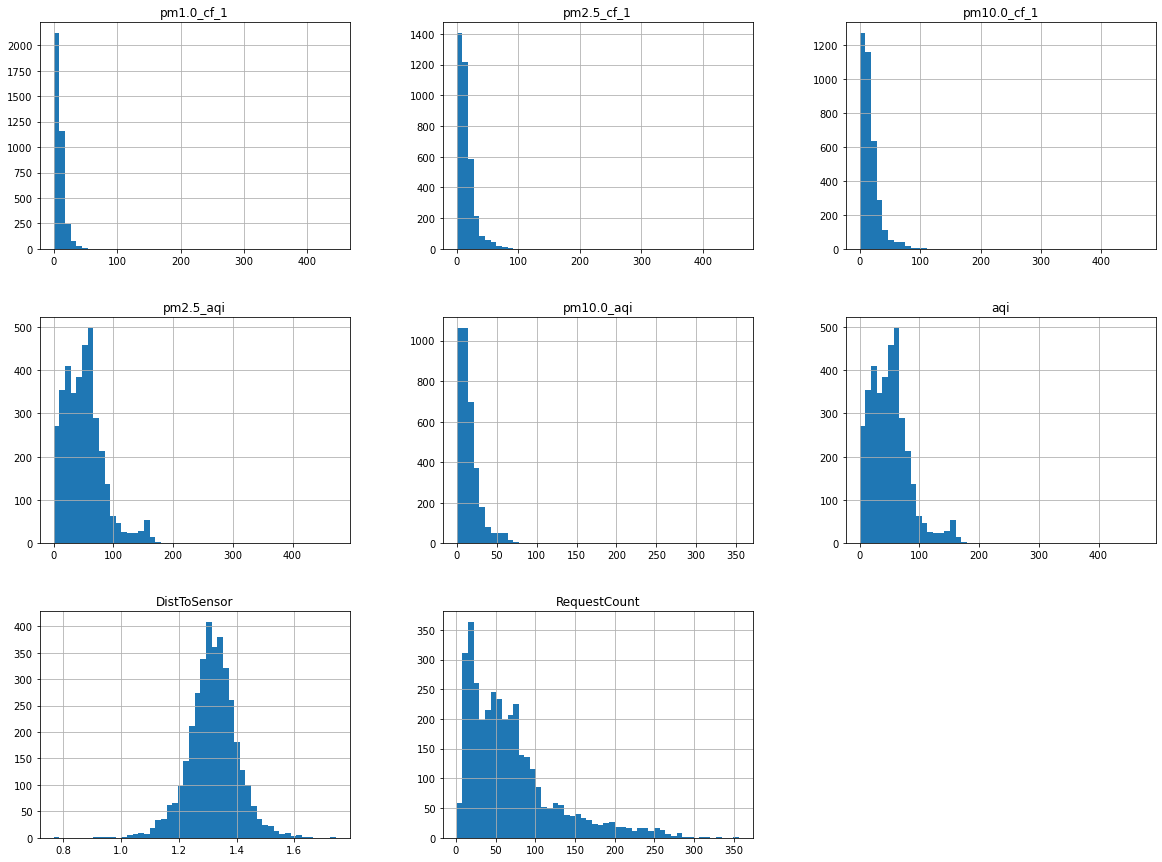

In [18]:
# Plot the histogram of each df_float's column
df_float.hist(bins=50, figsize=(20,15))

,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,DistToSensor,RequestCount
pm1.0_cf_1,1.000000,0.953336,0.926805,0.788921,0.886029,0.788921,-0.008839,0.050461
pm2.5_cf_1,0.953336,1.000000,0.994490,0.917023,0.978462,0.917023,-0.005192,0.044490
pm10.0_cf_1,0.926805,0.994490,1.000000,0.930352,0.988394,0.930352,-0.003478,0.035823
pm2.5_aqi,0.788921,0.917023,0.930352,1.000000,0.963188,1.000000,-0.006293,0.082624
pm10.0_aqi,0.886029,0.978462,0.988394,0.963188,1.000000,0.963188,-0.003364,0.046414
aqi,0.788921,0.917023,0.930352,1.000000,0.963188,1.000000,-0.006293,0.082624
DistToSensor,-0.008839,-0.005192,-0.003478,-0.006293,-0.003364,-0.006293,1.000000,-0.027048
RequestCount,0.050461,0.044490,0.035823,0.082624,0.046414,0.082624,-0.027048,1.000000


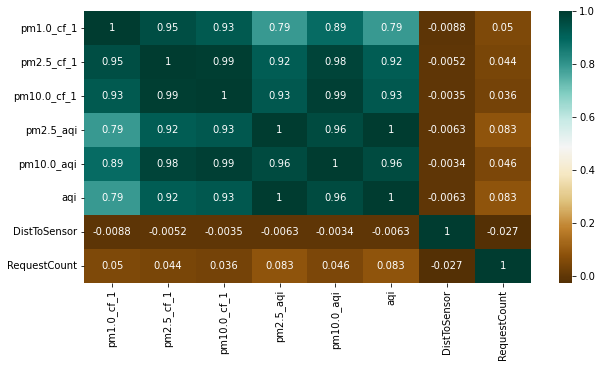

In [19]:
# Check the correlation (Pearson Correlation or r) between variables
plt.figure(figsize=(10,5))
c= df_float.corr()
sns.heatmap(c,cmap="BrBG",annot=True)
c

From the above heat map we can see that linear correllation between the `aqi`, `DistToSensor`, and `RequestsCount` is not very strong, since they are between -0.00063 and 0.083. Note that there is a very high correlation between `pm2.5`, `pm10`, `pm2.5_aqi`, `pm10_aqi`, and `aqi`. This is make sense since `pm2.5_aqi` is derived from `pm2.5`, similary `pm10_aqi` is derived from `pm10`, and the `aqi` is just the max of `pm2.5` and `pm10`.

We will add a column called "Level" which is the __Level of Concern__ based on the value of the aqi. The cut off was taken from [Air Quality Index (AQI) Basics](https://www.airnow.gov/aqi/aqi-basics/).

In [20]:
temp_list = []
level = ""
for i in range(len(req_aqi_df)):
    if req_aqi_df["aqi"][i] >= 301:
        level = "Hazardous"
    elif req_aqi_df["aqi"][i] >= 201:
        level = "Very Unhealthy"
    elif req_aqi_df["aqi"][i] >= 151:
        level = "Unhealthy"
    elif req_aqi_df["aqi"][i] >= 101:
        level = "Unhealthy for Sensitive Groups"
    elif req_aqi_df["aqi"][i] >= 51:
        level = "Moderate"
    elif req_aqi_df["aqi"][i] >= 0:
        level = "Good"
    else:
        level = None
    temp_list.append(level)

req_aqi_df["Level"] = temp_list

req_aqi_df.head()

,Date,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,sensor_index,SensorName,Sensor#,DistToSensor,RequestCount,Level
0,2021-01-01,3.0220,4.8420,5.5135,20,5,20,85645,AEnv,0.0,1.359005,17,Good
1,2021-01-02,13.1195,20.6330,22.9205,69,21,69,85645,AEnv,0.0,1.290715,26,Moderate
2,2021-01-03,11.5385,18.5800,20.7120,65,19,65,85645,AEnv,0.0,1.352132,38,Moderate
3,2021-01-04,12.7075,21.1295,23.7280,70,22,70,85645,AEnv,0.0,1.161365,24,Moderate
4,2021-01-05,6.4895,11.5610,13.3265,48,12,48,85645,AEnv,0.0,1.539138,14,Good


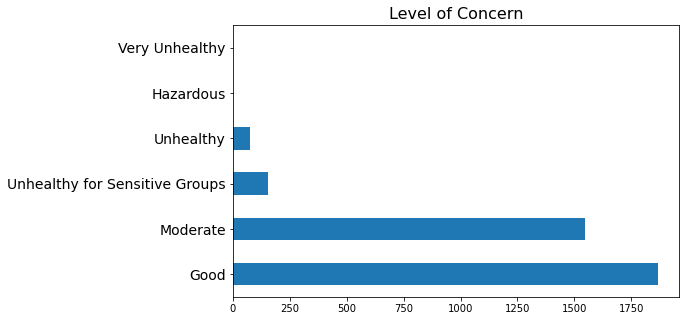

In [21]:
# Plot the level of AQI

req_aqi_df["Level"].value_counts().plot(kind="barh", figsize=(8,5))

plt.yticks(fontsize = 14)
plt.title('Level of Concern', fontsize = 16)

plt.show()

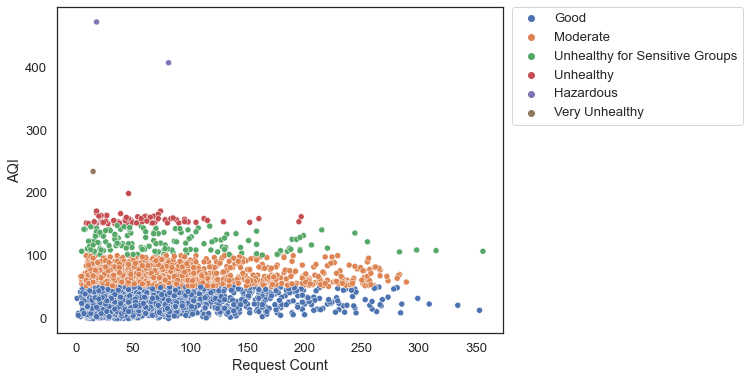

In [22]:
# Visualize the distribution of Level of Concern based on RequestCount and AQI

plt.figure(figsize = (8,6))
sns.set(style='white', font_scale = 1.2)
ax = sns.scatterplot(data=req_aqi_df, x=req_aqi_df["RequestCount"], y=req_aqi_df["aqi"], hue="Level")
#place legend outside top right corner of plot
ax.set_xlabel('Request Count')
ax.set_ylabel('AQI')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

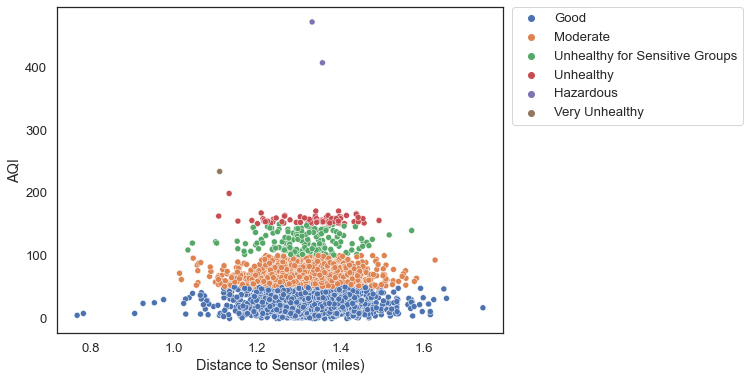

In [23]:
# Visualize the distribution of Level of Concern based on DistToSensor and AQI\

plt.figure(figsize = (8,6))
sns.set(style='white', font_scale = 1.2)
ax = sns.scatterplot(data=req_aqi_df, x=req_aqi_df["DistToSensor"], y=req_aqi_df["aqi"], hue="Level")
#place legend outside top right corner of plot
ax.set_xlabel('Distance to Sensor (miles)')
ax.set_ylabel('AQI')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

From the scatter plot above, we can see that there is no linear correlation between `DistToSensor` and `aqi`, and between `RequestCount` and `aqi`.

Let's visualize the scatter plot of `DistToSensor`, `RequestCount`, `AQI` from 20% randomly selected `req_aqi_df` rows.

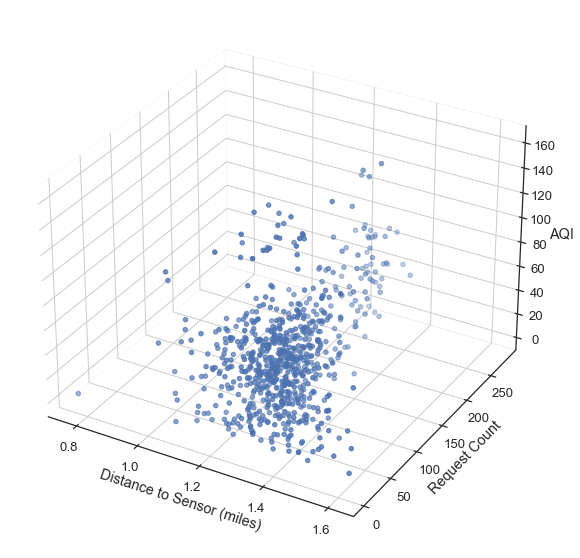

In [24]:
# Below is the scatter plot of the DistToSensor, RequestCount, AQI from random selection of req_aqi_df

# Randomly select 20% of req_aqi_df
random_20 = req_aqi_df.sample(frac = 0.2, random_state = 0)

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(random_20["DistToSensor"], random_20["RequestCount"], random_20["aqi"])

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Distance to Sensor (miles)')
ax.set_ylabel('Request Count')
ax.set_zlabel('AQI')

#ax.view_init(150, 50)

plt.show()

<h2>Removing Outliers</h2>

From the Exploratory Data Analysis which were done in [Tableau](https://public.tableau.com/app/profile/susan.kolim/viz/Investigaterelationshipbetweenairqualitydataand2021311requests/RequestsbySensorName?publish=yesa), we see that there are `AQI` values which are a lot higher than the rest of the data. Therefore, we need to remove them since they are considered as outliers. 

In [25]:
# Function to find lower and upper fences

def find_fences(df_column):
    Q1 = df_column.quantile(0.25)
    Q3 = df_column.quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1 - 1.5 * IQR
    upper_fence = Q3 + 1.5 * IQR
    fences = [lower_fence, upper_fence]
    return fences 

<h3>AQI Outliers</h3>

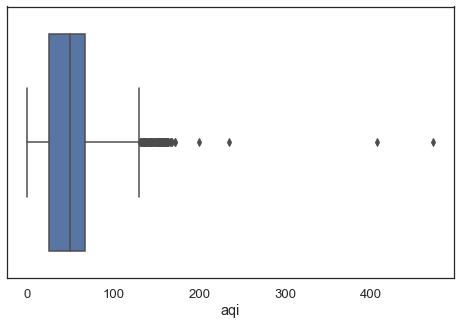

In [26]:
# Plot the AQI boxplot
plt.figure(figsize = (8,5))
sns.boxplot(x="aqi", data=req_aqi_df)
plt.show()

In [27]:
aqi_fences = find_fences(req_aqi_df['aqi'])

# Find the number of outliers below the lower fence
aqi1 = len(req_aqi_df.loc[req_aqi_df['aqi'] < aqi_fences[0]])

# Find the number of outliers above the upper fence
aqi2 = len(req_aqi_df.loc[req_aqi_df['aqi'] > aqi_fences[1]])

print(aqi1, aqi2)

0 130


<h3>DistToSensor Outliers</h3>

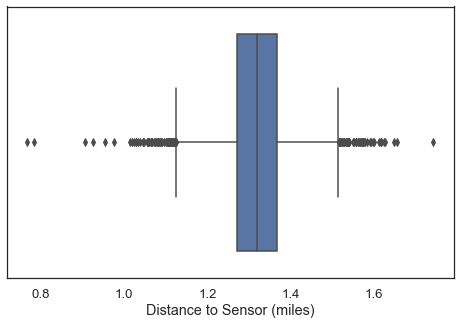

In [28]:
# Plot the DistToSensor boxplot
plt.figure(figsize = (8,5))
ax = sns.boxplot(x="DistToSensor", data=req_aqi_df)
ax.set_xlabel('Distance to Sensor (miles)')
plt.show()

In [29]:
dist_fences = find_fences(req_aqi_df['DistToSensor'])

# Find the number of outliers below the lower fence and above upper fence
dist1 = len(req_aqi_df.loc[req_aqi_df['DistToSensor'] < dist_fences[0]])
dist2 = len(req_aqi_df.loc[req_aqi_df['DistToSensor'] > dist_fences[1]])
print(dist1, dist2)

66 55


<h3>RequestCount Outliers</h3>

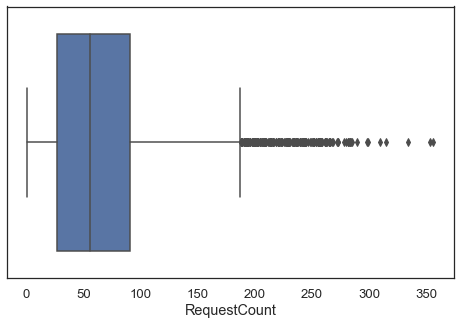

In [30]:
# Plot the RequestCount boxplot
plt.figure(figsize = (8,5))
sns.boxplot(x="RequestCount", data=req_aqi_df)
plt.show()

In [31]:
req_fences = find_fences(req_aqi_df['RequestCount'])

# Find the number of outliers below the lower fence
req1 = len(req_aqi_df.loc[req_aqi_df['RequestCount'] < req_fences[0]])
req2 = len(req_aqi_df.loc[req_aqi_df['RequestCount'] > req_fences[1]])
print(req1, req2)

0 210


In [32]:
# Calculate total outliers (these outliers can overlap)
total_outliers = aqi1+aqi2+dist1+dist2+req1+req2
total_outliers

461

<h3>Removing outliers from DistToSensor, RequestCount, AQI<h3>

In [33]:
# Remove the outliers and call the new dataset req_aqi_df1

# Remove outliers of AQI
req_aqi_df1 = req_aqi_df.drop(req_aqi_df.loc[req_aqi_df['aqi'] > aqi_fences[1]].index)

# Remove outliers of DistToSensor
req_aqi_df1 = req_aqi_df.drop(req_aqi_df.loc[(req_aqi_df['DistToSensor'] < dist_fences[0]) | (req_aqi_df['DistToSensor'] > dist_fences[1])].index)

# Remove outliers of RequestCount
req_aqi_df1 = req_aqi_df.drop(req_aqi_df.loc[req_aqi_df['RequestCount'] > req_fences[1]].index)

# Reset index
req_aqi_df1 = req_aqi_df1.reset_index(drop=True)
req_aqi_df1.head()

,Date,pm1.0_cf_1,pm2.5_cf_1,pm10.0_cf_1,pm2.5_aqi,pm10.0_aqi,aqi,sensor_index,SensorName,Sensor#,DistToSensor,RequestCount,Level
0,2021-01-01,3.0220,4.8420,5.5135,20,5,20,85645,AEnv,0.0,1.359005,17,Good
1,2021-01-02,13.1195,20.6330,22.9205,69,21,69,85645,AEnv,0.0,1.290715,26,Moderate
2,2021-01-03,11.5385,18.5800,20.7120,65,19,65,85645,AEnv,0.0,1.352132,38,Moderate
3,2021-01-04,12.7075,21.1295,23.7280,70,22,70,85645,AEnv,0.0,1.161365,24,Moderate
4,2021-01-05,6.4895,11.5610,13.3265,48,12,48,85645,AEnv,0.0,1.539138,14,Good


In [34]:
req_aqi_df1.shape

(3438, 13)

In [35]:
# Calculate the number of rows removed from req_aqi_df
(len(req_aqi_df) - len(req_aqi_df1))/len(req_aqi_df)*100

5.756578947368421

In [36]:
# Recalculate the statistical summary of aqi, DistToSensor, and RequestCount
req_aqi_df1[['aqi', 'DistToSensor', 'RequestCount']].describe()

,aqi,DistToSensor,RequestCount
count,3438.000000,3438.000000,3438.000000
mean,50.330134,1.318706,60.147760
std,34.062336,0.086842,41.043307
min,0.000000,0.767499,1.000000
25%,25.000000,1.269452,25.000000
50%,48.500000,1.319089,52.000000
75%,66.750000,1.370950,82.000000
max,472.000000,1.742714,187.000000


<h2>Multiple Linear Regression</h2>

<h3>Pre-Processing</h3>

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

In [38]:
y = req_aqi_df1["aqi"]
print(len(y))
y[0:5]

3438


0    20
1    69
2    65
3    70
4    48
Name: aqi, dtype: int64

In [39]:
x = req_aqi_df1[['DistToSensor', 'RequestCount']].values
print(x.shape)
x[0:5]

(3438, 2)


array([[ 1.35900474, 17.        ],
       [ 1.29071483, 26.        ],
       [ 1.3521317 , 38.        ],
       [ 1.16136522, 24.        ],
       [ 1.53913815, 14.        ]])

In [40]:
# Create test set and train set
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=0)
print ('Train set:', x_train.shape,  y_train.shape)
print ('Test set:', x_test.shape,  y_test.shape)

Train set: (2750, 2) (2750,)
Test set: (688, 2) (688,)


<h3>Training and Testing the dataset</h3>

In [41]:
lr=LinearRegression()
lr.fit(x_train, y_train)
print ('Coefficients: ', lr.coef_)
print ('Intercept: ',lr.intercept_)

Coefficients:  [-6.06075365  0.07120656]
Intercept:  53.7007164323525


Based on the above result, we obtained the following linear regression model:


$AQI = -6.0608 * DistToSensor + 0.071 * RequestCount + 53.7$

In [42]:
# Will use this later to evaluate the cross-validation

def display_scores(scores):
    print("r_squared:", scores)
    print("Mean of r_squared:", scores.mean())
    print("Standard deviation of r_squared:", scores.std())

In [43]:
# Use cross-validation to get an estimate of a model’s generalization

r2scores = cross_val_score(lr, x_train, y_train, cv=10)
display_scores(r2scores)

r_squared: [-0.01368451  0.00127422  0.01537048 -0.0057364  -0.01785927 -0.00277322
  0.02296068  0.01549977 -0.00106134  0.00220948]
Mean of r_squared: 0.0016199874050098705
Standard deviation of r_squared: 0.012376962574560698


The mean of $R^2$ score is 0.002, which is very low. This shows the model doesn't generalize well. Since only 0.2% of the variability observed in the __AQI__ is explained by the regression model.

In [44]:
y_hat= lr.predict(x_test)
print("Root Mean Square Error (RMSE): %.2f" % np.sqrt(np.mean((y_hat - y_test) ** 2)))
print("R2-score of test set: %.2f" % r2_score(y_test, y_hat) )
print("R2-score of train set: %.2f" % r2_score(y_train, lr.predict(x_train)) )

Root Mean Square Error (RMSE): 36.95
R2-score of test set: -0.00
R2-score of train set: 0.01


The $R^2$ of the test set and train set is extremely low, which means our data is not close to the fitted regression line. This show that there is low correlation between distance, request number, and AQI. This is not surprising since there are plenty of variables that can affect AQI, for example, number of cars in the area, vegetation, factories, population density, etc. can affect the AQI values in an area. The removal of _Bulky Items, Metal/Household Appliances, Graffiti, Homeless Encampment, Electronic Waste, Illegal Dumping, Dead Animal,_ and addressing _Multiple Streetlight Issue_ and _Single Streetlight Issue_ don't seems to have any impact in comparison to these variables.

<h3>Scatter Plot of Test Set</h3>

Below is the plot of the _DistToSensor_, _RequestCount_, and _AQI_ from the __test set__. We see that the linear regression plane cannot fit the scatter points since they are very disperse and doesn't seems to have any linear correlation at all.

In [45]:
x1 = [row[0] for row in x_test]
x2 = [row[1] for row in x_test]

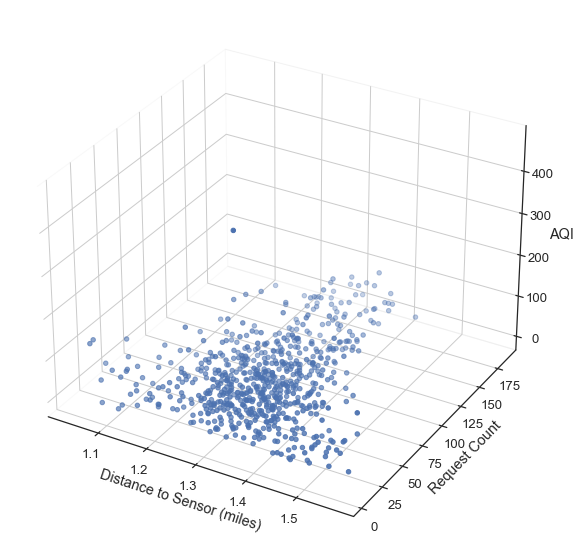

In [46]:
# Below is the scatter plot of the test set without the linear regression plane

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1, x2, y_test)

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Distance to Sensor (miles)')
ax.set_ylabel('Request Count')
ax.set_zlabel('AQI')

#ax.view_init(150, 50)

plt.show()

In [47]:
min(x1), max(x1)

(1.0337602120160025, 1.5714856586941448)

In [48]:
min(x2), max(x2)

(4.0, 187.0)

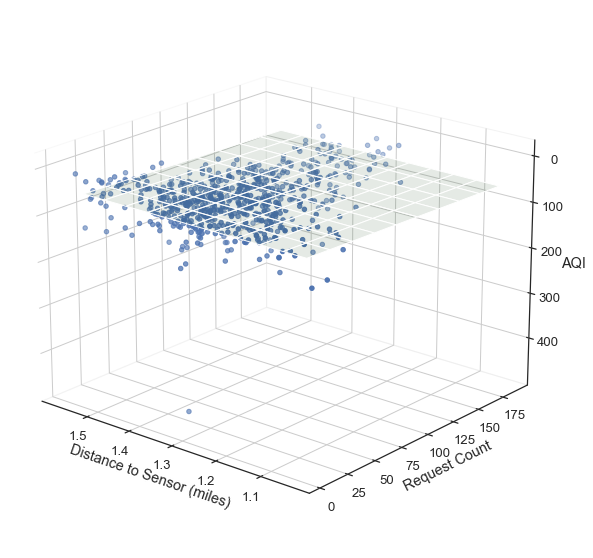

In [51]:
# Below is the scatter plot of the test set with linear regression plane
# The AQI axis is flipped for better visualization

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111,projection='3d')

ax.scatter(x1, x2, y_test)

x = np.arange(min(x1), 1.58, 0.05)
y = np.arange(min(x2), max(x2), 20)
xx, yy = np.meshgrid(x, y)
z = xx*lr.coef_[0] + yy*lr.coef_[1] + lr.intercept_

# plot the surface
ax.plot_surface(xx, yy, z, alpha=0.1, color = 'green')

# Remove fill
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.set_xlabel('Distance to Sensor (miles)')
ax.set_ylabel('Request Count')
ax.set_zlabel('AQI')

ax.view_init(-160, 50)

plt.show()